In [26]:
#LSTM

import numpy 
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
numpy.random.seed(7)



In [27]:
PULoc = 4

In [28]:
dataframe = pandas.read_csv('Demand_Data3_Train_CV_2017.csv', usecols=[4,3], engine='python', skipfooter=3)
dataframe = dataframe[dataframe['PULocationID'] == 4]
dataframe = dataframe['passenger_count']
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset = dataset[0:24*100]
dataset = np.reshape(dataset, (len(dataset),1))

In [29]:
Test = pandas.read_csv('Demand_Data3_Test_Predictions_2017.csv', usecols=[4,3], engine='python', skipfooter=3)
Test = Test[Test['PULocationID'] == 4]
Test = Test['passenger_count']
Test_Values = Test.values
Test_Values = Test_Values.astype('float32')
Test_Values = Test_Values[0:24*100]
Test_Values = np.reshape(Test_Values, (len(Test_Values),1))

In [30]:
#Preprocessing Training
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#Preprocessing Testing
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(Test_Values)



In [37]:
#Training/Testing Data (Train on Jan-Oct, Ttest on Nov-Dec)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#train_size = len(dataset)
#test_size = len(Test_Values)
#train = dataset
#test = Test_Values

In [38]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [39]:

# create and fit the LSTM network
model = Sequential()
#model.add(LSTM(1, input_shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=30, batch_size=10, verbose=2)



Epoch 1/30
 - 1s - loss: 0.0113
Epoch 2/30
 - 0s - loss: 0.0076
Epoch 3/30
 - 0s - loss: 0.0070
Epoch 4/30
 - 0s - loss: 0.0064
Epoch 5/30
 - 0s - loss: 0.0057
Epoch 6/30
 - 0s - loss: 0.0050
Epoch 7/30
 - 0s - loss: 0.0045
Epoch 8/30
 - 0s - loss: 0.0039
Epoch 9/30
 - 0s - loss: 0.0034
Epoch 10/30
 - 0s - loss: 0.0031
Epoch 11/30
 - 0s - loss: 0.0028
Epoch 12/30
 - 0s - loss: 0.0027
Epoch 13/30
 - 0s - loss: 0.0026
Epoch 14/30
 - 0s - loss: 0.0026
Epoch 15/30
 - 0s - loss: 0.0026
Epoch 16/30
 - 0s - loss: 0.0026
Epoch 17/30
 - 0s - loss: 0.0025
Epoch 18/30
 - 0s - loss: 0.0025
Epoch 19/30
 - 0s - loss: 0.0025
Epoch 20/30
 - 0s - loss: 0.0025
Epoch 21/30
 - 0s - loss: 0.0025
Epoch 22/30
 - 0s - loss: 0.0025
Epoch 23/30
 - 0s - loss: 0.0025
Epoch 24/30
 - 0s - loss: 0.0025
Epoch 25/30
 - 0s - loss: 0.0025
Epoch 26/30
 - 0s - loss: 0.0025
Epoch 27/30
 - 0s - loss: 0.0025
Epoch 28/30
 - 0s - loss: 0.0025
Epoch 29/30
 - 0s - loss: 0.0025
Epoch 30/30
 - 0s - loss: 0.0025


In [40]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 #invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))




Train Score: 14.75 RMSE
Test Score: 11.28 RMSE


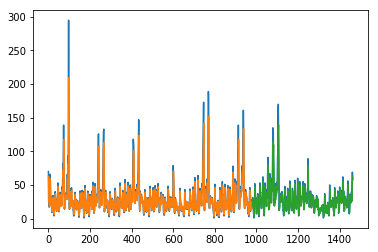

In [41]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)